In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path
from keras.preprocessing import image
import numpy as np
import tensorflow as tf

In [2]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential

In [28]:
train_dir = '/content/Indian-Currency-Classification-main/train'   

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
          #train_dir, 
    directory=r"C:\Users\ravip\Indian-Currency-Classification-main\Indian-Currency-Classification-main\train",
          labels='inferred', 
          label_mode='int',
          class_names=['10', '20', '50', '100', '200', '500', '2000'], 
          color_mode='rgb', 
          batch_size=32, 
          image_size=(224,224), 
          shuffle=True, 
          seed=123, 
          validation_split=0.2, 
          subset='training',
          interpolation='bicubic', 
          follow_links=False, 
          smart_resize=True
        )

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
          directory=r"C:\Users\ravip\Indian-Currency-Classification-main\Indian-Currency-Classification-main\train", 
          labels='inferred', 
          label_mode='int',
          class_names=['10', '20', '50', '100', '200', '500', '2000'], 
          color_mode='rgb', 
          batch_size=32, 
          image_size=(224,224), 
          shuffle=False, 
          seed=123, 
          validation_split=0.2, 
          subset='validation',
          interpolation='bicubic', 
          follow_links=False, 
          smart_resize=True
        )

Found 1239 files belonging to 7 classes.
Using 992 files for training.
Found 1239 files belonging to 7 classes.
Using 247 files for validation.


In [29]:
def normalize(image,label):
    """
    Returns normalized image and its label
    """ 
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [30]:
train_dataset = train_dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)

In [31]:
# import tensorflow as tf

def conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    filters = int(filters * alpha)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size=kernel,
                                        strides=strides,
                                        padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters,
                               kernel_size=(1, 1),
                               strides=(1, 1),
                               padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

def MobileNet(input_shape=(224, 224, 3), alpha=1.0, depth_multiplier=1, classes=1000):
    inputs = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(inputs)
    x = tf.keras.layers.Conv2D(int(32 * alpha),
                               kernel_size=(3, 3),
                               strides=(2, 2),
                               padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = conv_block(x, 64, alpha, strides=(1, 1))
    x = conv_block(x, 128, alpha, strides=(2, 2))
    x = conv_block(x, 128, alpha, strides=(1, 1))
    x = conv_block(x, 256, alpha, strides=(2, 2))
    x = conv_block(x, 256, alpha, strides=(1, 1))
    x = conv_block(x, 512, alpha, strides=(2, 2))

    for _ in range(depth_multiplier):
        x = conv_block(x, 512, alpha, strides=(1, 1))
    
    x = conv_block(x, 1024, alpha, strides=(2, 2))
    x = conv_block(x, 1024, alpha, strides=(1, 1))

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((1, 1, int(1024 * alpha)))(x)
    x = tf.keras.layers.Dropout(0.001)(x)
    x = tf.keras.layers.Conv2D(classes, kernel_size=(1, 1), padding='same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Activation('softmax')(x)

    model = tf.keras.models.Model(inputs, x, name='MobileNet')
    return model


In [32]:
model=MobileNet()

In [33]:
model.summary()

Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d_3 (ZeroPaddi  (None, 225, 225, 3)      0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_96 (Bat  (None, 112, 112, 32)     128       
 chNormalization)                                                
                                                                 
 re_lu_96 (ReLU)             (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_51 (Depthw  (None, 112, 112, 32)     32

 tchNormalization)                                               
                                                                 
 re_lu_111 (ReLU)            (None, 7, 7, 512)         0         
                                                                 
 conv2d_63 (Conv2D)          (None, 7, 7, 1024)        525312    
                                                                 
 batch_normalization_112 (Ba  (None, 7, 7, 1024)       4096      
 tchNormalization)                                               
                                                                 
 re_lu_112 (ReLU)            (None, 7, 7, 1024)        0         
                                                                 
 depthwise_conv2d_59 (Depthw  (None, 7, 7, 1024)       10240     
 iseConv2D)                                                      
                                                                 
 batch_normalization_113 (Ba  (None, 7, 7, 1024)       4096      
 tchNormal

In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
    )

In [48]:
model.fit(train_dataset,validation_data=validation_dataset,epochs=15)

Epoch 1/15
31/31 [==============================] - 125s 3s/step - loss: 0.0737 - accuracy: 0.9738 - val_loss: 4.7486 - val_accuracy: 0.4089
Epoch 2/15
31/31 [==============================] - 103s 3s/step - loss: 0.1342 - accuracy: 0.9526 - val_loss: 0.5601 - val_accuracy: 0.9109
Epoch 3/15
31/31 [==============================] - 102s 3s/step - loss: 0.1273 - accuracy: 0.9526 - val_loss: 1.8487 - val_accuracy: 0.7814
Epoch 4/15
31/31 [==============================] - 102s 3s/step - loss: 0.1139 - accuracy: 0.9627 - val_loss: 1.7570 - val_accuracy: 0.6761
Epoch 5/15
31/31 [==============================] - 102s 3s/step - loss: 0.0650 - accuracy: 0.9738 - val_loss: 0.6634 - val_accuracy: 0.8502
Epoch 6/15
31/31 [==============================] - 104s 3s/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 3.8876 - val_accuracy: 0.5466
Epoch 7/15
31/31 [==============================] - 114s 4s/step - loss: 0.0237 - accuracy: 0.9929 - val_loss: 0.5112 - val_accuracy: 0.8543
Epoch 8/15
31

In [49]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation:\n\tloss:{val_loss} \n\taccuracy:{val_acc}")

8/8 [==============================] - 6s 720ms/step - loss: 0.4432 - accuracy: 0.8907
Validation:
	loss:0.44315770268440247 
	accuracy:0.8906882405281067


In [50]:
test_dir = r"C:\Users\ravip\Indian-Currency-Classification-main\Indian-Currency-Classification-main\test"

test_imageID = []
# r=root, d=directories, f = files

for r, d, f in os.walk(test_dir, topdown=True):
    for file in f:
      if '.jpg' in file:
          test_imageID.append(Path(file).stem)
test_imageID = sorted(test_imageID)

In [51]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
          test_dir, 
          labels=None, 
          label_mode=None,
          class_names = None,
          color_mode='rgb', 
          batch_size=1,
          shuffle = False,
          image_size=(224,224), 
          interpolation='bicubic', 
          smart_resize=True
        )

Found 54 files belonging to 1 classes.


In [52]:
def normalize_test(image):
  """
    Returns normalized image and its label
  """
  image = tf.cast(image/255. ,tf.float32)
  return image

In [53]:
test_dataset = test_dataset.map(normalize_test)

In [54]:
predictions = model.predict(test_dataset)
pred_category = np.argmax(predictions,axis = 1)   

54/54 [==============================] - 4s 48ms/step


In [55]:
labels_name = ['10', '20', '50', '100', '200', '500', '2000']
pred_output_labels = [labels_name[i] for i in pred_category]

In [56]:
test_images = list(test_dataset.as_numpy_iterator()) 
num_test_images = len(test_images)

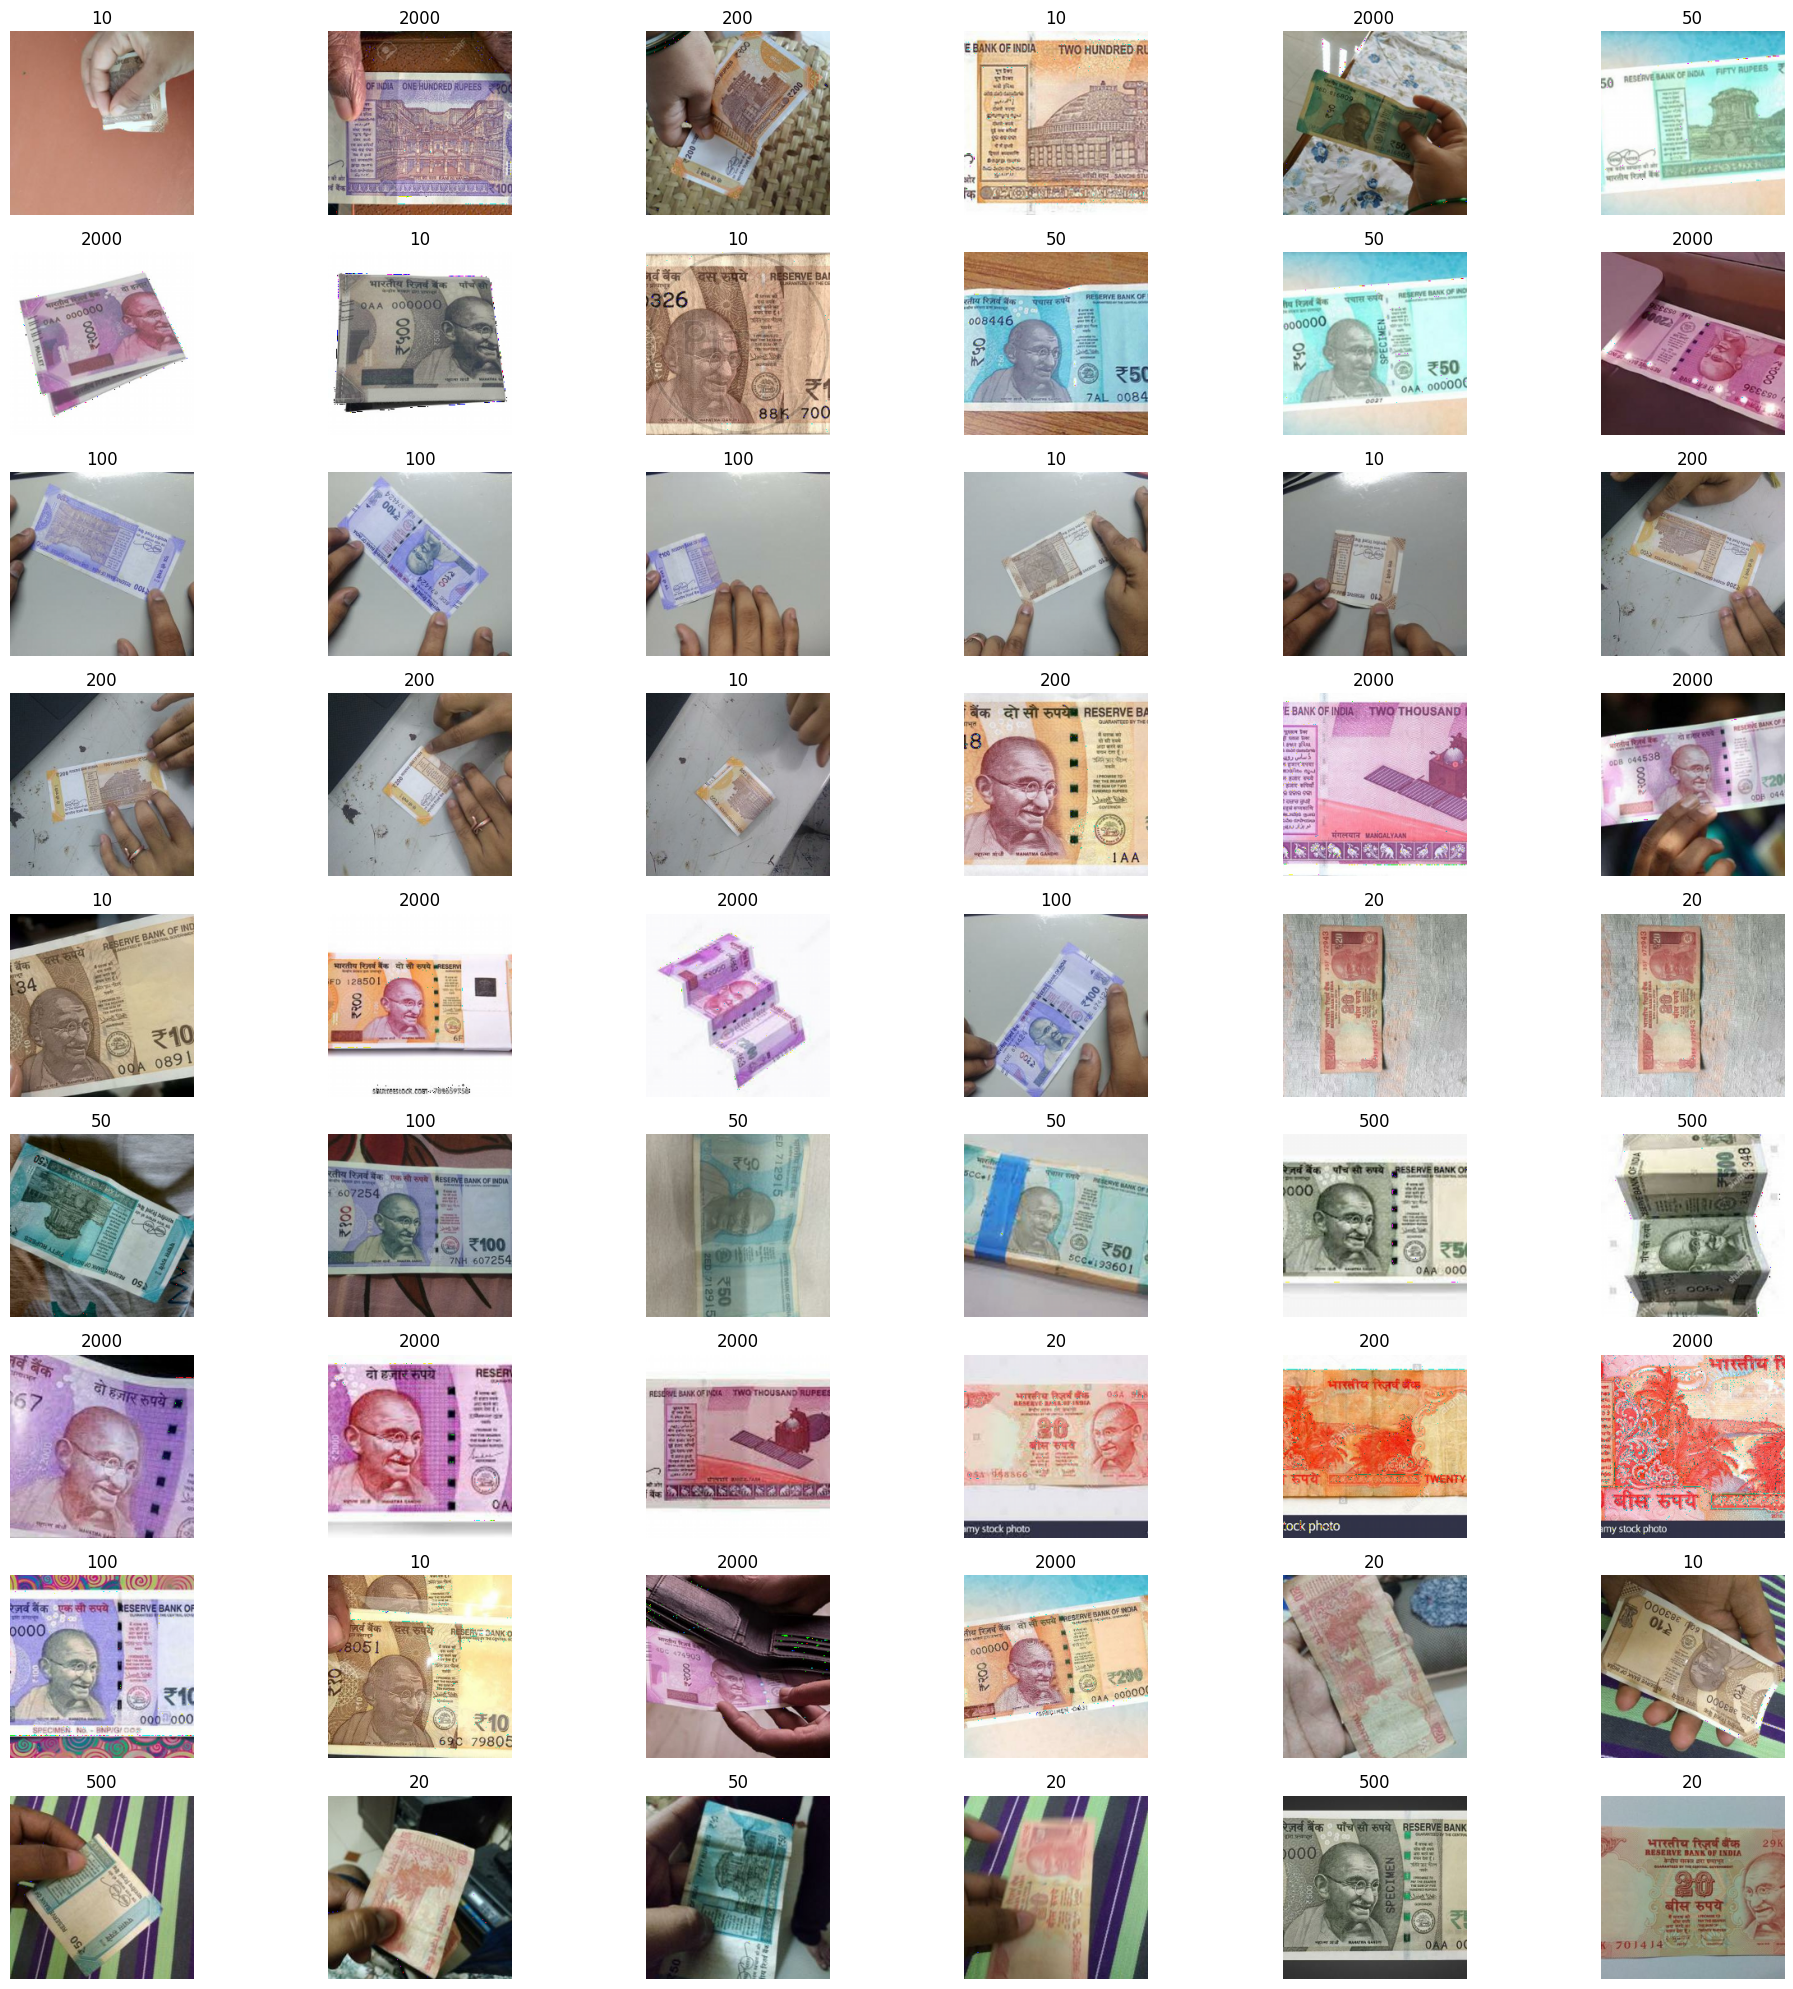

In [57]:
subplot_rows = num_test_images//6 + (1 if num_test_images%6!=0 else 0)
subplot_columns = num_test_images if num_test_images<6 else 6

plt.figure(figsize=(20, 20))
i = 0     

for images in test_images:
  ax = plt.subplot(subplot_rows, subplot_columns, i + 1)
  plt.imshow((np.squeeze(images) * 255).astype(np.uint8), cmap = 'gray')
  plt.title(pred_output_labels[i])
  plt.axis("off")
  i = i + 1

plt.tight_layout()
plt.show()

Following is our prediction:
1/1 [==============================] - 0s 109ms/step


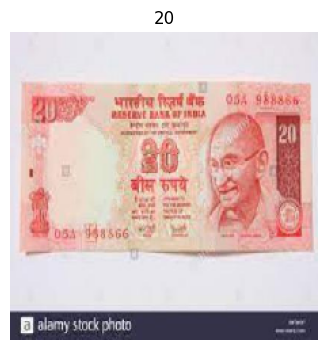

In [60]:
from tensorflow.keras.preprocessing import image
import numpy as np
image_path = "test/images.jpg"
new_img = image.load_img(image_path, target_size=(227, 227))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
print("Following is our prediction:")
prediction = model.predict(img)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
d = prediction.flatten()
j = d.max()
for index,item in enumerate(d):
    if item == j:
        class_name = labels_name[index]
#ploting image with predicted class name 
plt.figure(figsize = (4,4))
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name)
plt.show()